In [ ]:
import requests
import tarfile
import os
from collections import defaultdict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
import copy
from statistics import mean
from dataclasses import dataclass, field
import random
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report
from io import BytesIO
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset, Subset
from PIL import Image, UnidentifiedImageError
import torchvision.models as models
import torch.optim as optim
import timm
import cv2
from collections import Counter





In [ ]:
# Acuqisisco URL del file tar.gz
url = "https://proai-datasets.s3.eu-west-3.amazonaws.com/progetto-finale-flowes.tar.gz"

# Scarico il file
response = requests.get(url)

# Salvo il file scaricato
with open("progetto-finale-flowes.tar.gz", "wb") as file:
    file.write(response.content)

# Estraggo il file e conteggio i file estratti
extracted_files_count = 0
total_files_in_archive = 0

try:
    with tarfile.open("progetto-finale-flowes.tar.gz", "r:gz") as tar:
        # Ottiengo il numero totale di file nell'archivio
        total_files_in_archive = len(tar.getnames())

        # Estraggo tutti i file
        tar.extractall()
        extracted_files_count = len(tar.getnames())

    # Controllo il numero di file estratti nella directory
    extracted_directory = os.getcwd()
    extracted_files = os.listdir(extracted_directory)

    # Verifico se il numero di file estratti è uguale a quello previsto
    if extracted_files_count == total_files_in_archive:
        print(f"Successo! Tutti i {total_files_in_archive} file sono stati estratti correttamente.")
    else:
        print(f"Attenzione! Sono stati estratti {extracted_files_count} file, ma ci si aspettava {total_files_in_archive} file.")

except Exception as e:
    print(f"Si è verificato un errore durante l'estrazione: {e}")

Successo! Tutti i 3674 file sono stati estratti correttamente.


In [ ]:

# Percorso della directory del dataset
dataset_dir = "/content/progetto-finale-flowes"

#Definisco una funzione per cercare di indiviudare tenere traccia e eliminare i file non validi
def remove_corrupt_images(dataset_dir):
    invalid_files = []
    for root, _, files in os.walk(dataset_dir):
        for file in files:
            file_path = os.path.join(root, file)
            try:

                with Image.open(file_path) as img:
                    img.verify()  # Verifica l'integrità
            except (IOError, Image.UnidentifiedImageError):

                invalid_files.append(file_path)
                os.remove(file_path)

    # Stampo i file non validi rimossi
    if invalid_files:
        print("File non validi trovati e rimossi:")
        for invalid_file in invalid_files:
            print(f" - {invalid_file}")
    else:
        print("Nessun file non valido trovato.")

# Creo una Funzione per stampare la diversità delle classi
def print_class_diversity(dataset_dir):
    for split in ['train', 'valid', 'test']:
        split_dir = os.path.join(dataset_dir, split)
        dataset = datasets.ImageFolder(split_dir)
        class_counts = {cls: 0 for cls in dataset.classes}

        for _, label in dataset:
            class_counts[dataset.classes[label]] += 1

        print(f'Diversità delle classi nel {split} set:')
        for cls, count in class_counts.items():
            print(f' - {cls}: {count}')



# Comando per Esegure la pulizia per tutte le cartelle del dataset
remove_corrupt_images(dataset_dir)

# Comando per stampare la diversità delle classi per ciascun set
print_class_diversity(dataset_dir)



# Creo una Funzione per controllare la luminosità di un'immagine
def check_image_brightness(image_path):
    img = cv2.imread(image_path)
    if img is None:  # Controllo se l'immagine è stata caricata correttamente
        print(f"Impossibile caricare l'immagine: {image_path}")
        return None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mean_brightness = np.mean(gray)
    return mean_brightness

# Creo una Funzione per contare e ottenere le caratteristiche delle immagini
def analyze_images_in_sets(dataset_dir):
    characteristics = {
        'train': {
            'total': 0,
            'width': [],
            'height': [],
            'format': set(),
            'channels': set(),
            'pixel_count': [],
            'low_brightness_count': 0,
            'low_resolution_count': 0
        },
        'valid': {
            'total': 0,
            'width': [],
            'height': [],
            'format': set(),
            'channels': set(),
            'pixel_count': [],
            'low_brightness_count': 0,
            'low_resolution_count': 0
        },
        'test': {
            'total': 0,
            'width': [],
            'height': [],
            'format': set(),
            'channels': set(),
            'pixel_count': [],
            'low_brightness_count': 0,
            'low_resolution_count': 0
        }
    }

    for set_name in ['train', 'valid', 'test']:
        set_dir = os.path.join(dataset_dir, set_name)
        if not os.path.exists(set_dir):
            print(f"Attenzione: La directory {set_name} non esiste e verrà ignorata.")
            continue

        for class_name in os.listdir(set_dir):
            class_path = os.path.join(set_dir, class_name)
            if os.path.isdir(class_path):

                for file_name in os.listdir(class_path):
                    if file_name.endswith(('.png', '.jpg', '.jpeg')):  # Comando per Filtrare i formati di immagine
                        img_path = os.path.join(class_path, file_name)
                        try:

                            with Image.open(img_path) as img:
                                width, height = img.size
                                channels = len(img.getbands())  # Comando per Ottenere il numero di canali
                                pixel_count = width * height  # Comando per Calcolare il numero totale di pixel

                                # Comando per Aggiornare le caratteristiche
                                characteristics[set_name]['total'] += 1
                                characteristics[set_name]['width'].append(width)
                                characteristics[set_name]['height'].append(height)
                                characteristics[set_name]['format'].add(file_name.split('.')[-1].lower())
                                characteristics[set_name]['channels'].add(channels)
                                characteristics[set_name]['pixel_count'].append(pixel_count)

                                # Comando per Controllare la luminosità
                                brightness = check_image_brightness(img_path)
                                if brightness is not None and brightness < 50:  # Soglia di luminosità
                                    characteristics[set_name]['low_brightness_count'] += 1

                                # Comando per Controllare la risoluzione
                                if width < 128 or height < 128:  # Soglia di risoluzione
                                    characteristics[set_name]['low_resolution_count'] += 1

                        except UnidentifiedImageError:
                            pass

    return characteristics

# Comando per eseguire la funzione e ottienere le caratteristiche delle immagini presenti
image_characteristics = analyze_images_in_sets(dataset_dir)

# Stampo le caratteristiche
for set_name, stats in image_characteristics.items():
    total_images = stats['total']
    widths = stats['width']
    heights = stats['height']
    formats = stats['format']
    channels = stats['channels']
    pixel_counts = stats['pixel_count']
    low_brightness_count = stats['low_brightness_count']
    low_resolution_count = stats['low_resolution_count']

    print(f"\nCaratteristiche per il set {set_name}:")
    print(f"  Numero totale di immagini: {total_images}")

    if widths and heights:
        avg_width = sum(widths) / len(widths)
        avg_height = sum(heights) / len(heights)
        avg_pixel_count = sum(pixel_counts) / len(pixel_counts)
        print(f"  Dimensione media delle immagini: {avg_width:.2f} x {avg_height:.2f}")
        print(f"  Conteggio medio dei pixel per immagine: {avg_pixel_count:.2f}")

    print(f"  Formati di file presenti: {', '.join(formats)}")
    print(f"  Numero di canali presenti: {', '.join(map(str, channels))}")  # Comando per Convertire in stringa per stampare
    print(f"  Immagini con bassa luminosità: {low_brightness_count}")
    print(f"  Immagini con bassa risoluzione: {low_resolution_count}")

# Calcolo e stampo la diversità delle classi per ciascun set singolarmente
def print_class_diversity(dataset_dir):
    for set_name in ['train', 'valid', 'test']:
        set_dir = os.path.join(dataset_dir, set_name)
        if os.path.exists(set_dir):
            class_counts = Counter()  # Inizializza il contatore per ciascun set
            for class_name in os.listdir(set_dir):
                class_path = os.path.join(set_dir, class_name)
                if os.path.isdir(class_path):
                    class_counts[class_name] += len(os.listdir(class_path))

            print(f"\nDiversità delle Classi nel set {set_name}:")
            for class_name, count in class_counts.items():
                print(f"  Classe: {class_name}, Conteggio: {count}")


File non validi trovati e rimossi:
 - /content/progetto-finale-flowes/._README.dataset.txt
 - /content/progetto-finale-flowes/._valid
 - /content/progetto-finale-flowes/._.DS_Store
 - /content/progetto-finale-flowes/.DS_Store
 - /content/progetto-finale-flowes/README.roboflow.txt
 - /content/progetto-finale-flowes/._train
 - /content/progetto-finale-flowes/._README.roboflow.txt
 - /content/progetto-finale-flowes/._test
 - /content/progetto-finale-flowes/README.dataset.txt
 - /content/progetto-finale-flowes/test/._daisy
 - /content/progetto-finale-flowes/test/._dandelion
 - /content/progetto-finale-flowes/test/._.DS_Store
 - /content/progetto-finale-flowes/test/.DS_Store
 - /content/progetto-finale-flowes/test/dandelion/._5608832856_f5d49de778_jpg.rf.a8dc767f6b06720677e5976be3156a66.jpg
 - /content/progetto-finale-flowes/test/dandelion/._7243174412_d3628e4cc4_m_jpg.rf.3a171e63d844752eec452386e4362e4f.jpg
 - /content/progetto-finale-flowes/test/dandelion/._4552591312_02fe1dcc04_n_jpg.rf.

In [ ]:
"""Il dataset sembra ben strutturato e di buona qualità avendo le immagini
una dimensione uniforme di pixel e una risoluzione abbastanza alta di 512
, ma c'è spazio per migliorare l'equilibrio delle classi e la qualità delle immagini in alcune situazioni.
L'implementazione di strategie di data augmentation e una rigorosa valutazione delle prestazioni possono contribuire a
ottimizzare i risultati del modello, ad esempio : A causa della prevalenza della classe "dandelion" si potrebbero
 considerare l'uso di tecniche di data augmentation per aumentare la varietà delle immagini, stesso discorso
 per la risoluzione Ci sono alcune immagini con bassa luminosità (51 nel set di addestramento, 25 nel set di validazione e 10 nel set di test). Questo potrebbe essere risolto
 con la normalizzare dellle immagini e utilizzando le tecniche di data augmentation per migliorare la robustezza del modello contro variazioni di luminosità."""



'Il dataset sembra ben strutturato e di buona qualità avendo le immagini\nuna dimensione uniforme di pixel e una risoluzione abbastanza alta di 512\n, ma c\'è spazio per migliorare l\'equilibrio delle classi e la qualità delle immagini in alcune situazioni.\nL\'implementazione di strategie di data augmentation e una rigorosa valutazione delle prestazioni possono contribuire a\nottimizzare i risultati del modello, ad esempio : A causa della prevalenza della classe "dandelion" si potrebbero\n considerare l\'uso di tecniche di data augmentation per aumentare la varietà delle immagini, stesso discorso\n per la risoluzione Ci sono alcune immagini con bassa luminosità (51 nel set di addestramento, 25 nel set di validazione e 10 nel set di test). Questo potrebbe essere risolto\n con la normalizzare dellle immagini e utilizzando le tecniche di data augmentation per migliorare la robustezza del modello contro variazioni di luminosità.'

In [ ]:
# Definisco il dispositivo (GPU se disponibile)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Definisco il percorso principale per il dataset
data_dir = '/content/progetto-finale-flowes'

# Trasformazioni di base per Dandelion (senza data augmentation), normalizzazione di ImageNet
base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Trasformazioni di data augmentation per Daisy
augmentation_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=30),  # Rotazione casuale fino a 30 gradi
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),  # Variazioni casuali di colore
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # Normalizzazione di ImageNet
])

# Carico il dataset completo
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'train'))

# Suddivido le classi Daisy e Dandelion in dataset distinti
daisy_indices = [i for i, (_, label) in enumerate(train_dataset) if label == train_dataset.class_to_idx['daisy']]
dandelion_indices = [i for i, (_, label) in enumerate(train_dataset) if label == train_dataset.class_to_idx['dandelion']]

# Dataset per Daisy con data augmentation
daisy_dataset = Subset(train_dataset, daisy_indices)
daisy_dataset.dataset.transform = augmentation_transform  # Applico data augmentation solo per Daisy

# Dataset per Dandelion senza data augmentation
dandelion_dataset = Subset(train_dataset, dandelion_indices)
dandelion_dataset.dataset.transform = base_transform  # Nessuna data augmentation per Dandelion

# Combino i dataset per ottenere un dataset bilanciato
balanced_train_dataset = ConcatDataset([daisy_dataset, dandelion_dataset])

# Creo DataLoader del training
train_loader = DataLoader(balanced_train_dataset, batch_size=32, shuffle=True)

# Percorso per i set di validazione e test
val_data_dir = os.path.join(data_dir, 'valid')
test_data_dir = os.path.join(data_dir, 'test')

# Trasformazioni comuni per validation e test
common_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Carico i dataset di validazione e test
val_dataset = datasets.ImageFolder(root=val_data_dir, transform=common_transform)
test_dataset = datasets.ImageFolder(root=test_data_dir, transform=common_transform)

# Creo DataLoader per validazione e test
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Funzione per contare gli elementi di ciascuna classe
def count_classes(loader):
    class_counts = {0: 0, 1: 0}  # Supponendo che 0 = daisy e 1 = dandelion
    for _, labels in loader:
        for label in labels:
            class_counts[label.item()] += 1
    return class_counts

# Calcolo dei pesi di classe in base alla distribuzione
num_daisy = len(daisy_indices)
num_dandelion = len(dandelion_indices)
total_samples = num_daisy + num_dandelion

weight_daisy = total_samples / (2 * num_daisy)
weight_dandelion = total_samples / (2 * num_dandelion)

# Definisco i pesi come tensore per CrossEntropyLoss e sposto sulla GPU se disponibile
class_weights = torch.tensor([weight_daisy, weight_dandelion], dtype=torch.float32).to(device)

# Definisco la funzione di perdita con i pesi delle classi
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Stampo le dimensioni del dataset e dei pesi delle classi
print(f'Dimensioni del dataset bilanciato: {len(balanced_train_dataset)}')
print(f'Pesi delle classi: Daisy: {weight_daisy:.2f}, Dandelion: {weight_dandelion:.2f}')

# Conto gli elementi di ciascuna classe in train, validation e test set
train_class_counts = count_classes(train_loader)
val_class_counts = count_classes(val_loader)
test_class_counts = count_classes(test_loader)

print(f'Numero di elementi nel train_loader: Daisy: {train_class_counts[0]}, Dandelion: {train_class_counts[1]}')
print(f'Numero di elementi nel val_loader: Daisy: {val_class_counts[0]}, Dandelion: {val_class_counts[1]}')
print(f'Numero di elementi nel test_loader: Daisy: {test_class_counts[0]}, Dandelion: {test_class_counts[1]}')



"""Siccome inizialmente la classe daisy nel training set sembrava e sembra ancora abbastanza sbilanciata nei confronti di dandelion ho applicato
tecniche di data augmentation soprattutto su daisy per cercare di compensare lo squilibrio
della classe nei confronti di dandaleion  come la rotation la cancellazioen casaule o le variazione
causale di colori di cui alcune immagini sembravano gia soffrire comunque all'interno
dell'analisi esplorativa e cercato di aumentare i pesi della classe daisy per cercare di compensare
il minor numero del campione. Nel validation e test set i sbilanciamenti sembrano
non eccessivi"""


Dimensioni del dataset bilanciato: 1275
Pesi delle classi: Daisy: 1.21, Dandelion: 0.85
Numero di elementi nel train_loader: Daisy: 529, Dandelion: 746
Numero di elementi nel val_loader: Daisy: 163, Dandelion: 201
Numero di elementi nel test_loader: Daisy: 77, Dandelion: 105


"Siccome inizialmente la classe daisy nel training set sembrava e sembra ancora abbastanza sbilanciata nei confronti di dandelion ho applicato\ntecniche di data augmentation soprattutto su daisy per cercare di compensare lo squilibrio\ndella classe nei confronti di dandaleion  come la rotation la cancellazioen casaule o le variazione\ncausale di colori di cui alcune immagini sembravano gia soffrire comunque all'interno\ndell'analisi esplorativa e cercato di aumentare i pesi della classe daisy per cercare di compensare\nil minor numero del campione. Nel validation e test set i sbilanciamenti sembrano\nnon eccessivi"

In [ ]:




model = timm.create_model('efficientnet_b0', pretrained=True)
num_classes = len(train_dataset.classes)
model.classifier = nn.Linear(model.classifier.in_features, num_classes) # Modifico l'ultimo layer per sfruttare l'apprendimento del modello preaddestrato
model = model.to(device) # Sposto il modello sul dispositivo




# Definisco l'ottimizzatore
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Imposto iParametri per l' early stopping
best_val_loss = float('inf')
patience = 5
counter = 0


# Inizializzo le liste al fine di monitorare la perdita e l'accuratezza
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Epoch [1/50], Train Loss: 0.2381, Train Accuracy: 90.04%, Validation Loss: 0.1972, Validation Accuracy: 93.96%
Miglior modello salvato con perdita di validazione: 0.1972
Epoch [2/50], Train Loss: 0.1125, Train Accuracy: 96.08%, Validation Loss: 0.2844, Validation Accuracy: 90.93%
Epoch [3/50], Train Loss: 0.1022, Train Accuracy: 95.84%, Validation Loss: 0.1366, Validation Accuracy: 93.96%
Miglior modello salvato con perdita di validazione: 0.1366
Epoch [4/50], Train Loss: 0.0642, Train Accuracy: 97.73%, Validation Loss: 0.1525, Validation Accuracy: 95.33%
Epoch [5/50], Train Loss: 0.0456, Train Accuracy: 98.51%, Validation Loss: 0.1073, Validation Accuracy: 95.33%
Miglior modello salvato con perdita di validazione: 0.1073
Epoch [6/50], Train Loss: 0.0400, Train Accuracy: 98.67%, Validation Loss: 0.1912, Validation Accuracy: 95.05%
Epoch [7/50], Train Loss: 0.0304, Train Accuracy: 99.29%, Validation Loss: 0.1650, Validation Accuracy: 95.05%
Epoch [8/50], Train Loss: 0.0480, Train Accura

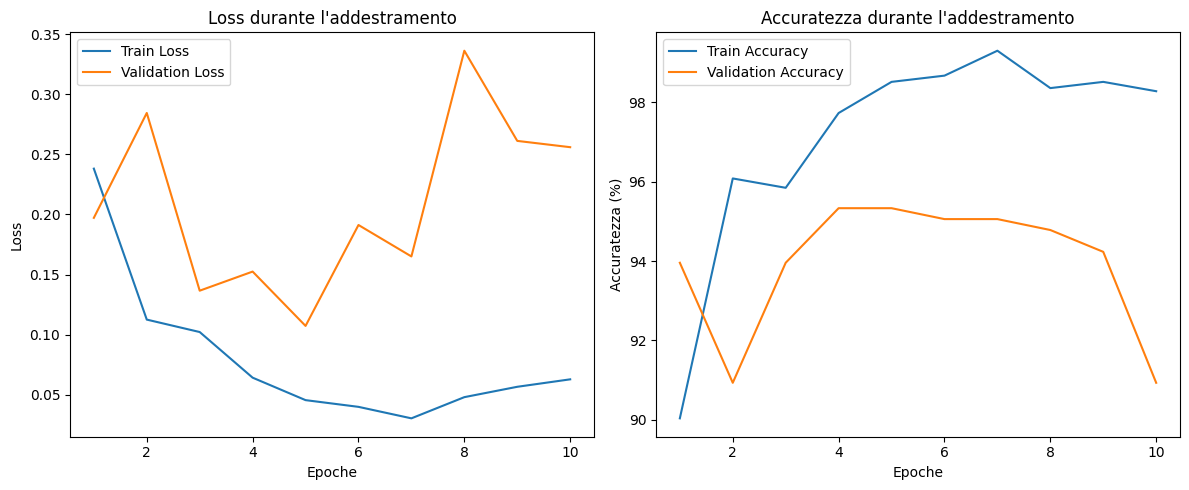

In [ ]:
# Eseguo il ciclo di addestramento
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)

    # Procedo con la valutazione del modello
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    # Stampo le metriche di addestramento e validazione
    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Train Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Comando per procedere con il salvataggio del miglior modello
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Miglior modello salvato con perdita di validazione: {val_loss:.4f}")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping attivato")
            break

# Imposto il Grafico dell'andamento della loss e dell'accuratezza
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Imposto il plot per poter visualizzare la loss e l'accuratezza dei training set e validation set durante l'addestramento
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Loss durante l\'addestramento')
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Accuratezza durante l\'addestramento')
plt.xlabel('Epoche')
plt.ylabel('Accuratezza (%)')
plt.legend()

plt.tight_layout()
plt.show()



<ipython-input-8-255ad0296544>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))  # Carico il miglior modello


              precision    recall  f1-score   support

       daisy       0.97      0.92      0.95        77
   dandelion       0.94      0.98      0.96       105

    accuracy                           0.96       182
   macro avg       0.96      0.95      0.95       182
weighted avg       0.96      0.96      0.96       182



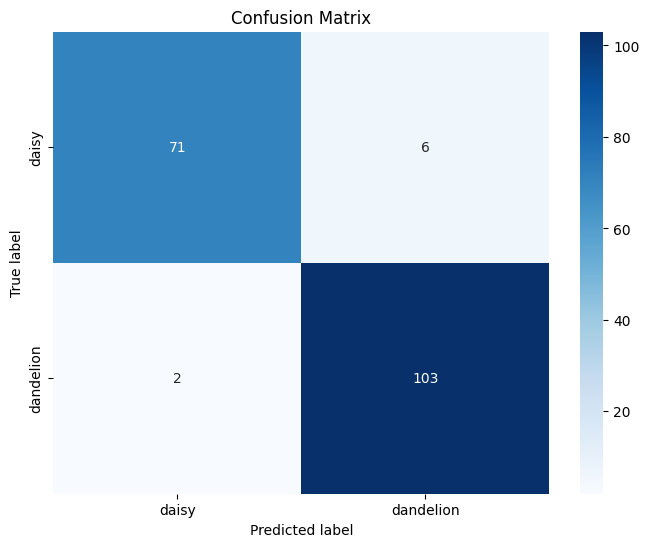

Matrice di Confusione:
           daisy  dandelion
daisy         71          6
dandelion      2        103


In [ ]:
# Procedo con la Validazione finale sul test set
model.load_state_dict(torch.load('best_model.pth'))  # Carico il miglior modello
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Stampo le metriche del classification report fornita dalla relativa libreria
print(classification_report(y_true, y_pred, target_names=test_dataset.classes))

# Procedo con la Creazione della matrice di confusione
conf_matrix = confusion_matrix(y_true, y_pred)

# Procedo con la Visualizzazione della matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

# Effettuo Calcolo della matrice di confusione
conf_matrix = confusion_matrix(y_true, y_pred)
classes = test_dataset.classes  # Le classi del tuo dataset


print("Matrice di Confusione:")
df_conf_matrix = pd.DataFrame(conf_matrix, index=classes, columns=classes)
print(df_conf_matrix)

# **CONSIDERAZIONI E CONCLUSIONI**

In [ ]:

"""Il presente modello descrive il processo di sviluppo di un modello di classificazione
delle immagini in grado di distinguere tra le classi "daisy" e "dandelion". Questo progetto è stato realizzato
on l'obiettivo di sviluppare un sistema automatizzato di riconoscimento delle immagini
che potrebbe avere interessanti
applicazioni di monitoraggio ambientale e analisi ecologica.

Dataset:

 Il dataset è costituito da immagini di fiori suddivise in due classi: daisy e dandelion raccolte le immagini nel link presenti del progetto
 che sono state soggetto poi successivamente a una fase di preprocessing. Si è eseguita una fase esplorativa del dataset per vedere se vi fosse un bilanciamento nella distribuzione delle immagini delle due classi presenti
 con una certo sbilanciamento a favore della classe dendalion


Preprocessing delle Immagini:

Tutte le immagini sono state ridimensionate a 224x224 pixel per garantire coerenza nelle dimensioni di input del modello.
Le immagini sono state normalizzate utilizzando la media e la deviazione standard dei valori dei pixel per migliorare la convergenza durante l'addestramento il tutto utilizzando come base
un procedimento di tipo transform per la generazione della pipeline e per la costruzione del modello si è proceduto a dividere le immagini complessive in modelli di training e validation per l'addestramento del modello
aggiungendo uno strato di validation per testarne unlteriormente l'accuratezza e infine un test di set per giudicare la bontà della predizione del modello in maniera indipendente rispetto all'addestramneto.

Per cercare di bilanciare lo sbilanciamento a favore della classe dendalion deifnita in fase esplorativa si è cercato di applicare tecniche di data agumentation e una modifica dei pesi a favore della classe daisy per cercare di correggere
bias di addestramento che potessero influenzare sia l'addestramento che la riuscita della fase di testing.


Data Augmentation: Per affrontare il problema dello sbilanciamento tra le classi, sono state adottate tecniche di data augmentation, in particolare per la classe "daisy", che includevano:


Rotazione casuale
Variazioni casuali di colore

.

Scelta del Modello si è selezionat il  EfficientNet B0, un modello di deep learning pre-addestrato, è stato scelto per la sua efficienza e accuratezza nel riconoscimento delle immagini e per rendere in tal senso molto piu efficiente il processo di addestramento a livello computazionale
in tal senso si è proceduto con la modifica del L'ultimo layer del modello è stato modificato per fare in modo che il modello fittasse con le due classi del dataset

Definizione della Funzione di Perdita e Ottimizzatore

per la Funzione di Perdita del modello È stata utilizzata la CrossEntropyLoss con pesi delle classi per affrontare il problema dello sbilanciamento tra le classi, come

otimizzatore è stato scelto quello di tipo Adam che si è rivelato essere quello piu efficace per la gestione del tasso di modello del modello.

Il modello poi è stato addestrato per 50 epoche con monitoraggio della perdita e dell'accuratezza su entrambi i set di training e validation.

È stata implementata poi anche una tecnica di early stopping per prevenire l'overfitting e in maniera tale che risultasse salvato e a sistema solo il modello con la migliore performance di validazione.

Per la valutazione del modello si sono utilizzate le metriche generati dal report di classificazione e la matrice di confusione:

Sono stati generati per analizzare le prestazioni del modello. Il modello ha mostrato un'accuratezza eccellente complessiva del 96%, con eccellenti valori di precisione e recall per entrambe le classi.

anche nella matrice di classificazione possiamo notare che solo 6 previsioni sono state errate con una maggiore difficolta nel distinguere la predizione dendalion per 6 volte il modello aveva previsto dendalion qunado in realtà si trattava di daisy.

Ciò nonostante il modello ha dimostrato di avere performance eccellenti.

Vantaggi e Sfide

Vantaggi:
Alte Prestazioni: Il modello ha dimostrato un'accuratezza elevata nella classificazione delle immagini.
Adattamento a Diverse Condizioni: Grazie all'uso della data augmentation, il modello può adattarsi meglio a variazioni nelle condizioni ambientali (es. illuminazione, angolazione delle foto).
Efficiente: L'uso di EfficientNet ha ridotto i requisiti computazionali pur mantenendo alte prestazioni.

Sfide:
Sbilanciamento del Dataset: Nonostante le tecniche di data augmentation, il bilanciamento tra le classi rimane una sfida.
Generalizzazione: La capacità del modello di generalizzare a nuovi dati può essere limitata se le immagini di test non rappresentano adeguatamente le condizioni reali.

Variabilità Ambientale: Fattori come l'illuminazione e lo sfondo delle immagini possono influenzare negativamente le prestazioni del modello.

Conclusioni
Il modello di classificazione sviluppato ha mostrato prestazioni solide e può essere implementato in scenari reali,
 come il monitoraggio di ecosistemi e la classificazione automatizzata di fiori. Tuttavia, è fondamentale continuare a migliorare e adattare il modello,
 considerando nuove fonti di dati e ulteriori tecniche di ottimizzazione per garantire risultati coerenti e affidabili.

Raccomandazioni
Ulteriore Raccolta Dati: Raccogliere dati aggiuntivi per migliorare il bilanciamento delle classi.

Validazione sul Campo: Testare il modello in condizioni reali per valutare la sua robustezza.

Sperimentazione con Altri Modelli: Esplorare altri modelli di deep learning per confrontare le prestazioni.

Applicare anche tecniche di regolarizzazione o di fine tuning per poter migliorare ulteriormente il modello nel corso di sperimentazioni o ampliamenti dal dataset

"""




'Il presente modello descrive il processo di sviluppo di un modello di classificazione\ndelle immagini in grado di distinguere tra le classi "daisy" e "dandelion". Questo progetto è stato realizzato\non l\'obiettivo di sviluppare un sistema automatizzato di riconoscimento delle immagini\nche potrebbe avere interessanti\napplicazioni di monitoraggio ambientale e analisi ecologica.\n\nDataset:\n\n Il dataset è costituito da immagini di fiori suddivise in due classi: daisy e dandelion raccolte le immagini nel link presenti del progetto\n che sono state soggetto poi successivamente a una fase di preprocessing. Si è eseguita una fase esplorativa del dataset per vedere se vi fosse un bilanciamento nella distribuzione delle immagini delle due classi presenti\n con una certo sbilanciamento a favore della classe dendalion\n\n\nPreprocessing delle Immagini:\n\nTutte le immagini sono state ridimensionate a 224x224 pixel per garantire coerenza nelle dimensioni di input del modello.\nLe immagini so